# Characterization of oncolytic VSV-IFN-γ

## Background 

In this project, VSV (Vesicular stomatitis virus) is being tested as an oncolytic virus. This version of VSV is engineered to stimulate the production of IFN-γ (interferon-gamma), a key immune molecule that in turn activates T cells, which are important for attacking tumors. 

## Research Goal 

To quantify and compare the virus’ effects on viral levels, IFN levels, and tumor size by fitting a mathematical model to experimental data. This helps determine what properties of the virus (e.g. infection rate, IFN stimulation, etc.) are most critical for eliminating tumors. With this, researchers can identify which strain has more favorable characteristics for oncolytic therapy.

## Mathematical Model 

We will use a model that includes the IFN response, 

$$ \dfrac{\mathrm{d}T}{\mathrm{d}t}  = \lambda T - \beta TV $$
$$ \dfrac{\mathrm{d}E}{\mathrm{d}t}  = \beta TV  - kE$$
$$ \dfrac{\mathrm{d}I}{\mathrm{d}t}  = kE - \delta I - \gamma I F$$
$$ \dfrac{\mathrm{d}V}{\mathrm{d}t}  = pI - cV$$
$$ \dfrac{\mathrm{d}F}{\mathrm{d}t}  = \eta I - \alpha F.$$

## Parameters 

| $\alpha$ | $\beta$ | $c$ | $\delta$ | $\eta$ | $\gamma$ | $k$ | $\lambda$ | $p$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| decay rate of IFN | infection rate | virus clearance | infected cell death rate | IFN production | infected cell removal rate | time for cells to become infectious | uninfected growth rate | virus production |

In [1]:
# importing libraries 

import math 
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

### Data Preparation

**Figure 1B (4T1 cells)** - Viral Growth Curve 
<br>
**Figure 2B** - IFN-γ Production (VSVΔ51 = 0)
<br>
**Figure 6A** - Tumor Growth in vivo

In [2]:
# figure 1B - viral titer
vsv51_1B = pd.read_csv("datasets/figure 1B/vsv51_pfu_.csv", header=None).to_numpy()
IFN_1B = pd.read_csv("datasets/figure 1B/vsv51-IFN_pfu_.csv", header=None).to_numpy()

# figure 2B - ifn level
vsv51_2B = pd.read_csv("datasets/figure 2B/vsv51_4T1_.csv", header=None).to_numpy()
IFN_2B = pd.read_csv("datasets/figure 2B/vsv51-IFNy_4T1_.csv", header=None).to_numpy()

# figure 6A 
vsv51_6A = pd.read_csv("datasets/figure 6A/vsv51.csv", header=None).to_numpy()
IFN_6A = pd.read_csv("datasets/figure 6A/vsv51-IFN.csv", header=None).to_numpy()
pbs = pd.read_csv("datasets/figure 6A/pbs.csv", header=None).to_numpy()

### Control Tumor Growth Analysis

**Goal: Determine λ (tumor growth rate) from PBS control data.**

<br />

Former:

The control tumor growth curve is given by

$$T(t) = T_0e^{λt},$$

where T0 is the initial tumor volume, which should be given in the text (~38.536 mm^3 - from the y-intercept of figure 6A). This
will allow us to find λ.

<br />

We're now using a linear model:

The control tumor growth line is given by

$$ \dfrac{\mathrm{d}T}{\mathrm{d}t}  = \frac {a T} {(T + b)} $$

Note that this has two parameters, a and b, rather than the single parameter of
the exponential model. This also does not have an simple closed-form solution
for T, so you will need to use minimize rather than curve fit to find the best fit.

In [3]:
time_data = pbs[:, 0]
volume_data = pbs[:, 1]

T0_v = 22.71879726 # initial tumor volume (for now at least)
lambda_growth = .1 # placeholder

def exponential_model(t, lambda_growth):
    return T0_v * np.exp(lambda_growth * t) 

In [4]:
popt, pcov = curve_fit(exponential_model, time_data, volume_data)
lambda_est = popt
lambda_est

array([0.16828213])

In [5]:
vals = []

for i in time_data: 
    y = exponential_model(i, lambda_est)
    vals.append(y)

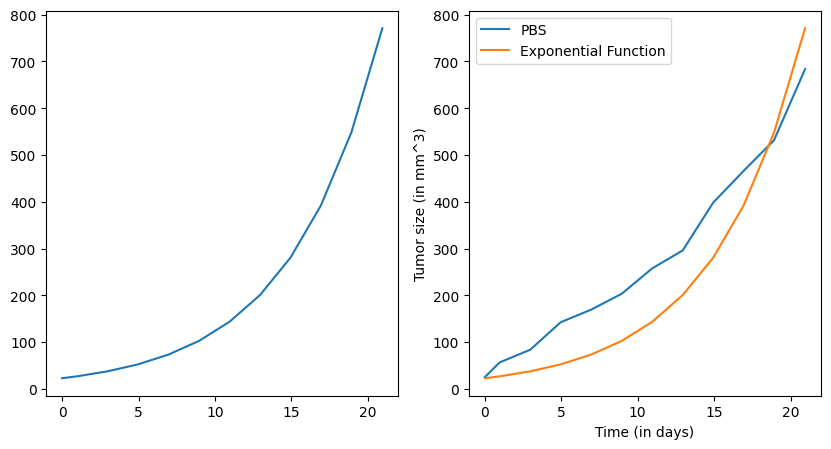

In [6]:
fig, axes = subplots(nrows=1,
                     ncols=2,
                     figsize=(10, 5))

axes[0].plot(time_data, vals, label='plot');

axes[1].plot(time_data, volume_data, label='PBS')
axes[1].plot(time_data, vals, label='Exponential Function');

plt.xlabel('Time (in days)')
plt.ylabel('Tumor size (in mm^3)')
plt.legend()
plt.show()

#### LINEAR FIT

In [7]:
def linear_model(t, T, a, b): 
    dTdt = (a * T) / (T + b)     
    
    return dTdt

def solve_linear_model(params, t_eval, T0_v):
    a, b = params
    sol = solve_ivp(lambda t, T: linear_model(T, t, a, b), [t_eval[0], t_eval[-1]], [T0_v], t_eval=t_eval)

    return sol.y[0] # return tumor volumes

def squared_residuals(params, t_data, T_data, T0_v):
    T_pred = solve_linear_model(params, t_data, T0_v)
    return np.sum((T_data - T_pred) ** 2)

In [8]:
initial_guess = [100, 10] # a and b

result = minimize(squared_residuals, initial_guess, args=(time_data, volume_data, T0_v), method="Nelder-Mead")

a_fit, b_fit = result.x
result.x

array([50.45576088,  5.704711  ])

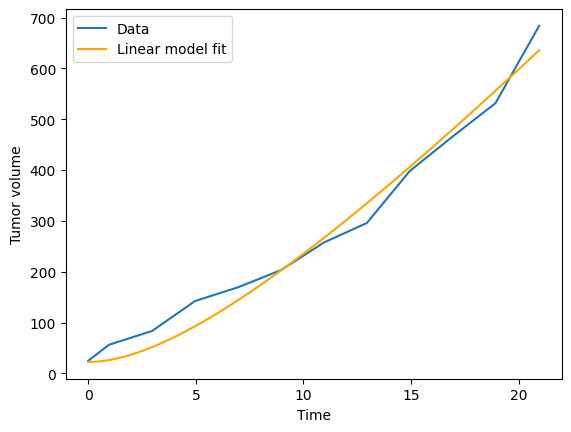

In [9]:
t_fit = np.linspace(time_data[0], time_data[-1], 100)
T_fit = solve_linear_model([a_fit, b_fit], t_fit, T0_v)

plt.plot(time_data, volume_data, label="Data")
plt.plot(t_fit, T_fit, label="Linear model fit", color="orange")
plt.xlabel("Time")
plt.ylabel("Tumor volume")
plt.legend()
plt.show()

# much better fit! we'll use this.

### In Vitro Viral Dynamics

We will get the virus/IFN dynamics by fitting the curves of Fig. 1B and 2B
together to a simplified model,

$$ \dfrac{\mathrm{d}T}{\mathrm{d}t}  = -\beta TV $$
$$ \dfrac{\mathrm{d}E}{\mathrm{d}t}  = \beta TV  - kE$$
$$ \dfrac{\mathrm{d}I}{\mathrm{d}t}  = kE - \delta I$$
$$ \dfrac{\mathrm{d}V}{\mathrm{d}t}  = pI - cV$$
$$ \dfrac{\mathrm{d}V}{\mathrm{d}t}  = \eta I - \alpha F.$$

We’ve left off the growth of target cells since these experiments are done in
a dish where there is little cell growth. We’ve also removed the effect of T
cells since these are not produced during in vitro experiments.

Fitting will be
done via minimization of the sum of squared residuals (SSR) using python’s
scipy.optimize.minimize function. Since we are using both curves, the SSR
will consist of two parts, one for IFN and one for virus. Since these two curves
are on different scales, we will use a weighted SSR that adjusts the size of each
point,

$$ SSR = \sum^{n}_{i=1} \left(\frac {\log_{10}(v_i) - \log_{10}(V(t_i;\theta))} {\log_{10}(v_i)} \right)^2 + \sum^{m}_{j=1} \left(\frac {l_j - F(t_i;\theta)} {l_j} \right)^2, $$

where $n$ is the number of viral data points, $v_i$ are the viral load values, $V(t_i;\theta)$
are the model viral load predictions at the times when the experimental data are
measured, $\theta$ is the set of parameters to be estimated, $m$ is the number of $IFN$
data points, $l_j$ are the $IFN$ values, and $F(t_j;\theta)$ are the model $IFN$ predictions
at the times when the experimental data are measured. A small $SSR$ indicates a
tight fit of the model to the experimental data. This will give us the parameters
$β$, $k$, $δ$, $p$, $c$, $η$, and $α$.

In [10]:
# ODE system

def viral_dynamics(t, y, B, k, d, p, c, n, a, e):
    T, E, I, V, F = y
    
    dTdt = (-B * T * V)/(1 + e*F)                   # uninfected cells get infected
    dEdt = ((B * T * V)/(1 + e*F)) - k * E             # eclipse phase cells
    dIdt = k * E - d * I                # infectious cells  
    dVdt = p * I - c * V                    # virus particles
    dFdt = n * I - a * F              # interferon production

    return [dTdt, dEdt, dIdt, dVdt, dFdt]

In [11]:
def simulate(y0, params, t_span, t_eval):
    solution = solve_ivp(viral_dynamics, t_span, y0, t_eval=t_eval, args=tuple(params), method="RK45")
    return solution.y # 5x7 = T,E,I,V,F for each timestamp

In [12]:
# initial conditions

T0 = 1e6
E0 = 0 
I0 = 0
V0 = vsv51_1B[0, 1]
F0 = 0

# parameters 

B=1e-8
k=2
d=.4
p=90
c=.01
n=0.5
a=1
e=1e-9

y0 = [T0, E0, I0, V0, F0]
params = (B, k, d, p, c, n, a, e)
t_span = (0, 48)
t_eval = np.linspace(0, 48, 7)

In [13]:
sol = simulate(y0, params, t_span, t_eval)
sol = sol.T
sol

array([[1.00000000e+06, 0.00000000e+00, 0.00000000e+00, 8.61953566e+00,
        0.00000000e+00],
       [9.99987772e+05, 2.98421323e+00, 5.72257008e+00, 7.88727938e+02,
        1.74142513e+00],
       [9.97902994e+05, 5.09620597e+02, 9.78462715e+02, 1.34917117e+05,
        2.97741150e+02],
       [7.11824993e+05, 6.07549649e+04, 1.34084415e+05, 2.06606045e+07,
        4.34239639e+04],
       [8.52692801e+01, 4.02465141e+02, 1.03805388e+05, 1.92156327e+08,
        7.83497759e+04],
       [9.35646192e-06, 2.01777510e-04, 4.25730454e+03, 1.98618043e+08,
        3.54469628e+03],
       [2.58565014e-08, 8.55137248e-07, 1.73591628e+02, 1.84214423e+08,
        1.44658310e+02]])

[1.00000000e+06 9.99987772e+05 9.97902994e+05 7.11824993e+05
 8.52692801e+01 9.35646192e-06 2.58565014e-08]


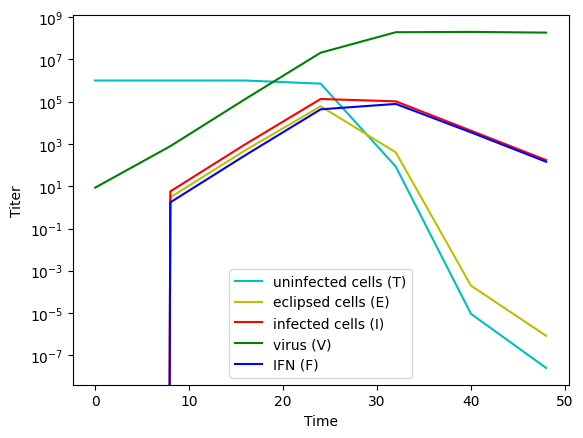

In [14]:
T = sol[:, 0] # uninfected cells at each time point
E = sol[:, 1] # eclipsed cells at each time point
I = sol[:, 2] # infected cells at each time point
V = sol[:, 3] # virus titer at each time point
F = sol[:, 4] # IFN levels at each time point

print(T)

plt.plot(t_eval, T, label='uninfected cells (T)', color='c')
plt.plot(t_eval, E, label='eclipsed cells (E)', color='y')
plt.plot(t_eval, I, label='infected cells (I)', color='r')
plt.plot(t_eval, V, label='virus (V)', color='g')
plt.plot(t_eval, F, label='IFN (F)', color='b')

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Titer')
plt.legend()
plt.show()

#### Calculating SSR 

In [15]:
eps = 1e-6  # small constant

def SSR_parent(params, y0, t_virus, t_ifn, virus, ifn):
    try:   
        t_eval_sim = np.linspace(t_span[0], t_span[1], 100) # smooth interpolation
        sol = simulate(y0, params, t_span, t_eval_sim)
        sol = sol.T

        V_sim = sol[:, 3] # virus titer at each time point 
        F_sim = sol[:, 4] # IFN levels at each time point 
        
        # interpolate simulation results to match data time points
        V_interp = np.interp(t_virus, t_eval_sim, V_sim)
        F_interp = np.interp(t_ifn, t_eval_sim, F_sim)
         
        # calculate virus SSR on log scale
        virus_ssr = np.sum(((np.log10(virus) - np.log10(V_interp)) / np.log10(virus))**2)

        # print(np.log10(virus), np.log10(V_interp))
    
        # calculate IFN SSR on linear scale (as per formula)
        ifn_ssr = 0

        print("PARENT SSR: ", virus_ssr + ifn_ssr, virus_ssr, ifn_ssr)
        return virus_ssr + ifn_ssr
        
    except Exception as e:
        print(f"Error in simulation or SSR calculation: {e}")
        return np.inf


In [16]:
def SSR_ifn(params, y0, t_virus, t_ifn, virus, ifn):
    try:  
        t_eval_sim = np.linspace(t_span[0], t_span[1], 100) # smooth interpolation
        sol = simulate(y0, params, t_span, t_eval_sim)
        sol = sol.T

        V_sim = sol[:, 3] # virus titer at each time point 
        F_sim = sol[:, 4] # IFN levels at each time point 
        
        # interpolate simulation results to match data time points
        V_interp = np.interp(t_virus, t_eval_sim, V_sim)
        F_interp = np.interp(t_ifn, t_eval_sim, F_sim)
        
        # calculate virus SSR on log scale
        virus_ssr = np.sum(((np.log10(virus) - np.log10(V_interp)) / np.log10(virus))**2)
        
        # calculate IFN SSR on linear scale (as per formula)
        ifn_ssr = np.sum(((ifn - F_interp) / (ifn))**2)

        print("IFN SSR: ", virus_ssr + ifn_ssr, virus_ssr, ifn_ssr)
        return virus_ssr + ifn_ssr
        
    except Exception as e:
        print(f"Error in simulation or SSR calculation: {e}")
        return np.inf

In [ ]:
# initial_guess_p = [B, k, d, p, c, n, a, e]
# initial_guess_ifn = [B, k, d, p, c, n, a, e]

initial_guess_p = [2.41871334e-05, 1.12801992e-04, 3.2e-2, 7.56610659e+02,
        7.14931881e-02, 0, 0, 8.60044470e-04]
initial_guess_ifn = [2.57167750e-06, 3.00561744e-02, 2.09665921e+02, 3.62026477e+03,
        1.24573539e-03, 1.08971826e+01, 4.98663113e-02, 3.74332265e-05]

# data for the parent strain (VSVΔ51) - Figure 1B virus, Figure 2B IFN
virus_parent = vsv51_1B[:, 1]
ifn_parent = vsv51_2B[:, 1]
t_virus_parent = vsv51_1B[:, 0]
t_ifn_parent = vsv51_2B[:, 0]

# data for the IFN-γ strain (VSVΔ51-IFNγ) - Figure 1B virus, Figure 2B IFN
virus_IFN = IFN_1B[:, 1]
ifn_IFN = IFN_2B[:, 1]
t_virus_IFN = IFN_1B[:, 0]
t_ifn_IFN = IFN_2B[:, 0]

y0 = [T[0], E[0], I[0], V[0], F[0]]

bounds = ((0, 1e6),(0, 1e6),(0, 1e6),(0, 1e6),(0, 1e6),(0, 1e6),(0, 1e6),(0, 1e6))

# fitting for the parent strain (VSVΔ51)
result_parent = minimize(SSR_parent, initial_guess_p, args=(y0, t_virus_parent, t_ifn_parent, virus_parent, ifn_parent), method="Nelder-Mead", bounds=bounds)
params_parent = result_parent.x

# fitting for the IFN-γ strain (VSVΔ51-IFNγ)
result_IFN = minimize(SSR_ifn, initial_guess_ifn, args=(y0, t_virus_IFN, t_ifn_IFN, virus_IFN, ifn_IFN), method="Nelder-Mead", bounds=bounds)
params_IFN = result_IFN.x

# fitting for the IFN-γ strain (VSVΔ51-IFNγ)
result_IFN = minimize(SSR_ifn, params_IFN, args=(y0, t_virus_IFN, t_ifn_IFN, virus_IFN, ifn_IFN), method='Nelder-Mead', bounds=bounds)
params_IFN = result_IFN.x

# # fitting for the IFN-γ strain (VSVΔ51-IFNγ)
# result_IFN = minimize(SSR_ifn, params_IFN, args=(y0, t_virus_IFN, t_ifn_IFN, virus_IFN, ifn_IFN), method='Nelder-Mead', bounds=bounds)
# params_IFN = result_IFN.x

params_parent, params_IFN

# # fitting for the IFN-γ strain (VSVΔ51-IFNγ)
# result_IFN = minimize(SSR_ifn, params_IFN, args=(y0, t_virus_IFN, t_ifn_IFN, virus_IFN, ifn_IFN), method='Nelder-Mead')
# params_IFN = result_IFN.x

# params_parent, params_IFN

In [77]:
# params_parent = [2.41729199e-05, 1.02661683e-04, 0, 8.31666922e+02,
#         7.15502723e-02, 0, 0, 2.07722279e-03]
# params_IFN = [1.96143066e-06, 2.33246153e-02, 2.83132132e+02, 8.25379529e+03,
#         4.57814226e-04, 2.53076732e+01, 8.08829495e-02, 4.05079590e-04]

params_parent = [2.91978223e-05, 1.90662945e-04, 3.15740438e-02, 4.14392345e+02,
        1.57110653e-01, 0, 0, 2.39482589e-05]
params_IFN = [2.46346359e-06, 9.90593250e-03, 4.12695329e+02, 2.26974562e+04,
        4.11951909e-02, 7.15915822e+01, 9.28649482e-02, 1.49902929e-03]

In [18]:
sol_new = simulate(y0, params_IFN, t_span, t_eval)
sol_new = sol_new.T 
sol_new

array([[1.00000000e+06, 0.00000000e+00, 0.00000000e+00, 8.61953566e+00,
        0.00000000e+00],
       [9.31858614e+05, 6.75064841e+04, 1.61794744e+00, 3.35693065e+04,
        1.01238654e+02],
       [4.54348706e+04, 9.07973068e+05, 2.17879290e+01, 2.27194129e+06,
        6.22362103e+03],
       [3.60275600e+02, 8.81145782e+05, 2.11861823e+01, 4.99916859e+06,
        1.17400779e+04],
       [1.17884965e+00, 8.14348962e+05, 1.95665793e+01, 6.73539761e+06,
        1.37666469e+04],
       [1.73594168e-03, 7.52305866e+05, 1.80504691e+01, 7.74514998e+06,
        1.41078517e+04],
       [1.25682278e-06, 6.94988654e+05, 1.66882987e+01, 8.25039477e+06,
        1.36942769e+04]])

[1.00000000e+06 9.31858614e+05 4.54348706e+04 3.60275600e+02
 1.17884965e+00 1.73594168e-03 1.25682278e-06]


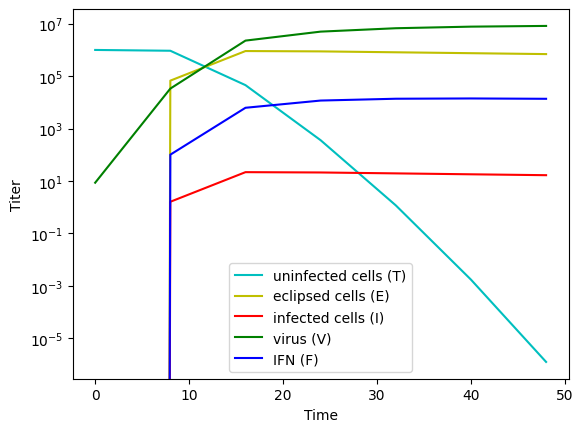

In [19]:
T = sol_new[:, 0] # uninfected cells at each time point
E = sol_new[:, 1] # eclipsed cells at each time point
I = sol_new[:, 2] # infected cells at each time point
V = sol_new[:, 3] # virus titer at each time point
F = sol_new[:, 4] # IFN levels at each time point

print(T)

plt.plot(t_eval, T, label='uninfected cells (T)', color='c')
plt.plot(t_eval, E, label='eclipsed cells (E)', color='y')
plt.plot(t_eval, I, label='infected cells (I)', color='r')
plt.plot(t_eval, V, label='virus (V)', color='g')
plt.plot(t_eval, F, label='IFN (F)', color='b')

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Titer')
plt.legend()
plt.show()

#### Plotting!

[8.61953566e+00 5.27023598e+04 1.81089829e+06 4.44834921e+06
 6.85605334e+06 8.82640269e+06 1.03814434e+07] [0. 0. 0. 0. 0. 0. 0.]
[8.61953566e+00 3.36654646e+04 2.27291246e+06 4.99993238e+06
 6.73586548e+06 7.74540964e+06 8.25051232e+06] [    0.           101.52615786  6226.04016667 11741.38615651
 13767.05796459 14107.84698851 13694.09432606]


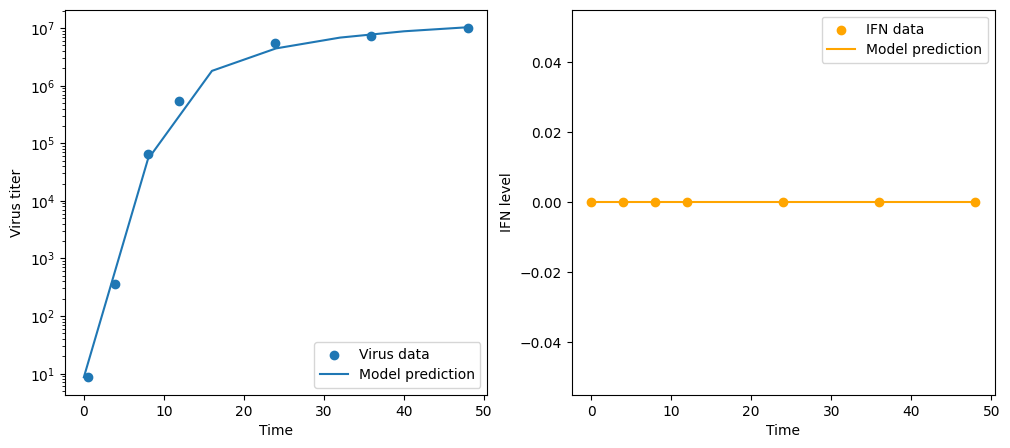

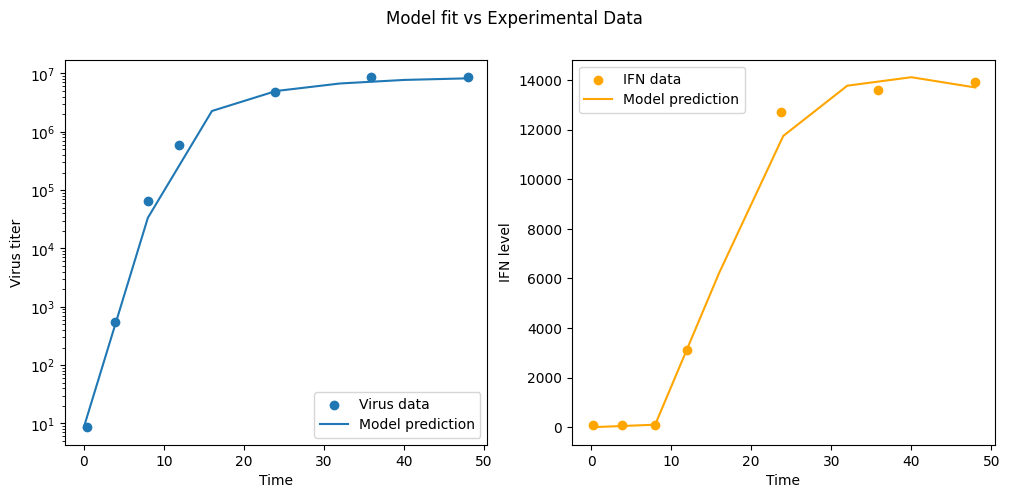

In [78]:
T0 = 1e6
t_span = (0, 48)
t_eval = np.linspace(0, 48, 7)
y0 = [T0, E0, I0, V0, F0]

def simulate_model(y0, params, t_span, t_eval):
    sol = solve_ivp(viral_dynamics, t_span, y0, t_eval=t_eval, args=tuple(params), method="LSODA")
    return sol.t, sol.y.T 

# pick condtion (parent virus or virus+IFN)
pt_sim = np.linspace(0, max(vsv51_1B[:,0].max(), vsv51_2B[:,0].max()), 200)
pt_out, psol = simulate_model(y0, params_parent, t_span, t_eval)
pt_out, psol = simulate_model(y0, params_parent, t_span, t_eval)

pV_pred = psol[:, 3]  # virus
pF_pred = psol[:, 4]  # IFN

print(pV_pred, pF_pred)

ft_sim = np.linspace(0, max(vsv51_1B[:,0].max(), vsv51_2B[:,0].max()), 200)
ft_out, fsol = simulate_model(y0, params_IFN, t_span, t_eval)
ft_out, fsol = simulate_model(y0, params_IFN, t_span, t_eval)

fV_pred = fsol[:, 3]  # virus
fF_pred = fsol[:, 4]  # IFN

print(fV_pred, fF_pred)

# plot overlays
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# virus parent
ax[0].scatter(vsv51_1B[:,0],vsv51_1B[:,1], label="Virus data")
ax[0].plot(pt_out, pV_pred, label="Model prediction")
ax[0].set_yscale("log")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Virus titer")
ax[0].legend()

# IFN parent
ax[1].scatter(vsv51_2B[:,0], vsv51_2B[:,1], label="IFN data", color="orange")
ax[1].plot(pt_out, pF_pred, label="Model prediction", color="orange")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("IFN level")
ax[1].legend()

# plot overlays
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# virus IFN
ax[0].scatter(IFN_1B[:,0],IFN_1B[:,1], label="Virus data")
ax[0].plot(ft_out, fV_pred, label="Model prediction")
ax[0].set_yscale("log")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Virus titer")
ax[0].legend()

# IFN IFN
ax[1].scatter(IFN_2B[:,0], IFN_2B[:,1], label="IFN data", color="orange")
ax[1].plot(ft_out, fF_pred, label="Model prediction", color="orange")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("IFN level")
ax[1].legend()

plt.suptitle("Model fit vs Experimental Data")
plt.show()

### Tumor Growth Data 

The final step is to include fitting the tumor growth data to determine all the parameters. We will use the full model for data fitting the tumor, but we'll assume that model parameters are the same in vivo and in vitro. We assume virus is injected at the same time as the tumor. The SSR will now include a third component where we compare the tumor size to T + E + I since all three cell types make up the tumor. 

In [79]:
def full_model_parent(t, y, g): 
    B, k, d, p, c, n, a, e = params_parent
    T, E, I, V, F = y 

    dTdt = ((a_fit * T)/(T + b_fit)) - ((B * T * V)/(1 + e*F))                    # uninfected cells get infected
    dEdt = ((B * T * V)/(1 + e*F)) - k * E             # eclipse phase cells
    dIdt = k * E - d * I - g * I * F                # infectious cells  
    dVdt = p * I - c * V                    # virus particles
    dFdt = n * I - a * F              # interferon production  

    # print("dTdt: ", ((a_growth * T)/(T + b_growth))*T - ((B * T * V)))

    n_type = np.float64

    if (type(dTdt) != n_type or type(dEdt) != n_type or type(dIdt) != n_type):
        print("PARAMS: ", g)
        print("Y: ", y)
        print(f"Types: dTdt={type(dTdt)}, dEdt={type(dEdt)}, dIdt={type(dIdt)}")
        print(f"Shapes: T={np.shape(T)}, E={np.shape(E)}, I={np.shape(I)}")
        print(f"Values: dTdt={dTdt}, dEdt={dEdt}, dIdt={dIdt}, dVdt={dVdt}, dFdt={dFdt}")
    
    return [dTdt, dEdt, dIdt, dVdt, dFdt]

In [80]:
def full_model_IFN(t, y, n, a, g): 
    B, k, d, p, c, _, _, e = params_IFN
    T, E, I, V, F = y
    
    dTdt = ((a_fit * T)/(T + b_fit)) - ((B * T * V)/(1 + e*F))                   # uninfected cells get infected
    dEdt = ((B * T * V)/(1 + e*F)) - k * E             # eclipse phase cells
    dIdt = k * E - d * I - g * I * F                # infectious cells  
    dVdt = p * I - c * V                    # virus particles
    dFdt = n * I - a * F              # interferon production  

    # print("dTdt: ", ((a_growth * T)/(T + b_growth))*T - ((B * T * V)))

    n_type = np.float64
    
    if (type(dTdt) != n_type or type(dEdt) != n_type or type(dIdt) != n_type):
        print("PARAMS: ", n, a, g)
        print("Y: ", y)
        print(f"Types: dTdt={type(dTdt)}, dEdt={type(dEdt)}, dIdt={type(dIdt)}")
        print(f"Shapes: T={np.shape(T)}, E={np.shape(E)}, I={np.shape(I)}")
        print(f"Values: dTdt={dTdt}, dEdt={dEdt}, dIdt={dIdt}, dVdt={dVdt}, dFdt={dFdt}")
    
    return [dTdt, dEdt, dIdt, dVdt, dFdt]

In [81]:
t_span = (0, 22)
t_eval = np.linspace(0, 22, 12)

T0_g = 22.71879726 
V0_g = 0
y0_g = [T0_g, 0, 0, V0_g, 0]

# def simulate_parent(y0, params, t_span, t_eval):
#     solution = solve_ivp(full_model_parent, t_span, y0, t_eval=t_eval, args=tuple(params), method="BDF")
#     return solution.y # 5x7 = T,E,I,V,F for each timestamp
    
# def simulate_IFN(y0, params, t_span, t_eval):
#     solution = solve_ivp(full_model_IFN, t_span, y0, t_eval=t_eval, args=tuple(params), method="BDF")
#     return solution.y # 5x7 = T,E,I,V,F for each timestamp

In [98]:
def SSR_full_parent(params, y0, t_virus, t_ifn, t_tumor, virus, ifn, tumor): 
    g = params[0]

    print("G: ", g)

    all_T, all_E, all_I = [], [], []
    all_times = []
    
    try:  
        T,E,I,V,F = y0

        # Day 0 to Day 1 (no virus yet)
        sol = solve_ivp(full_model_parent, (0, 1), [T, E, I, V, F], 
                       t_eval=np.linspace(0, 1, 10), 
                       args=(g,), 
                       method="BDF", rtol=1e-6, atol=1e-8)

        all_times.extend(sol.t)
        all_T.extend(sol.y[0])
        all_E.extend(sol.y[1])
        all_I.extend(sol.y[2])
        
        T = sol.y[0, -1]
        E = sol.y[1, -1]
        I = sol.y[2, -1]
        V = sol.y[3, -1]
        F = sol.y[4, -1]

        V += 1e5

        # Days 1-5: inject virus at START of each day
        for day in range(2, 6):
            print(f"Day {day}: V before injection = {V:.2e}, T = {T:.2e}")
            sol = solve_ivp(full_model_parent, (day, day+1), [T, E, I, V, F], 
                          t_eval=np.linspace(day, day+1, 10), 
                          args=(g,), 
                          method="BDF", rtol=1e-6, atol=1e-8)
            
            if not sol.success or sol.y.size == 0:
                return np.inf
            
            all_times.extend(sol.t)
            all_T.extend(sol.y[0])
            all_E.extend(sol.y[1])
            all_I.extend(sol.y[2])
        
            T = sol.y[0, -1]
            E = sol.y[1, -1]
            I = sol.y[2, -1]
            V = sol.y[3, -1]
            F = sol.y[4, -1]

            print(f"Day {day}: After simulation, V = {V:.2e}, T = {T:.2f}")
            
            if np.any(np.isnan([T,E,I,V,F])) or np.any(np.isinf([T,E,I,V,F])):
                return np.inf
            
            # Inject at START of next day (if not day 5)
        
            V += 1e5
            print(f"Day {day}: After injection, V = {V:.2e}")

        # print("V: ", V)

        t_eval_sim = np.linspace(5, 22, 100) # smooth interpolation
        sol = solve_ivp(full_model_parent, (5,22), [T,E,I,V,F], t_eval=t_eval_sim, args=(g,), method="BDF", rtol=1e-8, atol=1e-10)
        T = sol.y[0, -1]
        E = sol.y[1, -1]
        I = sol.y[2, -1]
        V = sol.y[3, -1]
        F = sol.y[4, -1] 

        # print(T,E,I,V,F)
        
        all_times.extend(sol.t)
        all_T.extend(sol.y[0])
        all_E.extend(sol.y[1])
        all_I.extend(sol.y[2])

        all_times = np.array(all_times)
        all_T = np.array(all_T)
        all_E = np.array(all_E)
        all_I = np.array(all_I)
        
        T_interp = np.interp(t_tumor, all_times, all_T)
        E_interp = np.interp(t_tumor, all_times, all_E) 
        I_interp = np.interp(t_tumor, all_times, all_I)

        print("tumor pred: ", T_interp + E_interp + I_interp)

        total_cells = T_interp + E_interp + I_interp
        predicted_volume = total_cells
        
        # calculate tumor SSR 
        tumor_ssr = np.sum(((tumor - predicted_volume) / tumor)**2)
        
        print("SSR PARENT:", tumor_ssr)
        
        return tumor_ssr
        
    except Exception as e:
        print(f"Error in simulation or SSR calculation: {e}")
        return np.inf

In [97]:
def SSR_full_IFN(params, y0, t_virus, t_ifn, t_tumor, virus, ifn, tumor): 
    n,a,g = params
    g = params[2]

    all_T, all_E, all_I = [], [], []
    all_times = []
    
    try:  
        T,E,I,V,F = y0
 
        # Day 0 to Day 1 (no virus yet)
        sol = solve_ivp(full_model_IFN, (0, 1), [T, E, I, V, F], 
                       t_eval=np.linspace(0, 1, 100), 
                       args=(n, a, g), 
                       method="BDF", rtol=1e-6, atol=1e-8)

        all_times.extend(sol.t)
        all_T.extend(sol.y[0])
        all_E.extend(sol.y[1])
        all_I.extend(sol.y[2])
        
        T = sol.y[0, -1]
        E = sol.y[1, -1]
        I = sol.y[2, -1]
        V = sol.y[3, -1]
        F = sol.y[4, -1]

        V += 1e5 
        
        # Days 1-5: inject virus at START of each day
        for day in range(2, 6):
            print(f"Day {day}: V before injection = {V:.2e}, T = {T:.2e}")
            sol = solve_ivp(full_model_IFN, (day, day+1), [T, E, I, V, F], 
                          t_eval=np.linspace(day, day+1, 100), 
                          args=(n, a, g), 
                          method="BDF", rtol=1e-6, atol=1e-8)
            
            if not sol.success or sol.y.size == 0:
                return np.inf
            
            all_times.extend(sol.t)
            all_T.extend(sol.y[0])
            all_E.extend(sol.y[1])
            all_I.extend(sol.y[2])
        
            T = sol.y[0, -1]
            E = sol.y[1, -1]
            I = sol.y[2, -1]
            V = sol.y[3, -1]
            F = sol.y[4, -1]
            print(f"Day {day}: After simulation, V = {V:.2e}, T = {T:.2f}")
            
            if np.any(np.isnan([T,E,I,V,F])) or np.any(np.isinf([T,E,I,V,F])):
                return np.inf
            
            # Inject at START of next day (if not day 5)
        
            V += 1e5
            print(f"Day {day}: After injection, V = {V:.2e}")

        # print("V: ", V)

        t_eval_sim = np.linspace(5, 22, 100) # smooth interpolation
        sol = solve_ivp(full_model_IFN, (5,22), [T,E,I,V,F], t_eval=t_eval_sim, args=(n,a,g), method="BDF", rtol=1e-8, atol=1e-10)
        T = sol.y[0, -1]
        E = sol.y[1, -1]
        I = sol.y[2, -1]
        V = sol.y[3, -1]
        F = sol.y[4, -1] 

        # print(T,E,I,V,F)
        
        all_times.extend(sol.t)
        all_T.extend(sol.y[0])
        all_E.extend(sol.y[1])
        all_I.extend(sol.y[2])
        
        # NOW interpolate from complete trajectory
        all_times = np.array(all_times)
        all_T = np.array(all_T)
        all_E = np.array(all_E)
        all_I = np.array(all_I)
        
        T_interp = np.interp(t_tumor, all_times, all_T)
        E_interp = np.interp(t_tumor, all_times, all_E)
        I_interp = np.interp(t_tumor, all_times, all_I)
        
        print("tumor pred: ", T_interp + E_interp + I_interp)

        total_cells = T_interp + E_interp + I_interp
        predicted_volume = total_cells 
        
        # calculate tumor SSR 
        tumor_ssr = np.sum(((tumor - predicted_volume) / tumor)**2)

        print("SSR IFN:", tumor_ssr)

        return tumor_ssr
        
    except Exception as e:
        print(f"Error in simulation or SSR calculation: {e}")
        return np.inf

In [86]:
_, _, _, c_p, _, n_p, a_p, _ = params_parent
_, _, _, c_ifn, _, n_ifn, a_ifn, _ = params_IFN

n_ifn, a_ifn

(71.5915822, 0.0928649482)

In [85]:
guesses_p = (c_p, 0.1)
guesses_IFN = (c_ifn,n_ifn, a_ifn, 0.1)

# data for the parent strain (VSVΔ51) - Figure 1B virus, Figure 2B IFN
virus_parent = vsv51_1B[:, 1]
ifn_parent = vsv51_2B[:, 1]
t_virus_parent = vsv51_1B[:, 0]
t_ifn_parent = vsv51_2B[:, 0]

# data for the IFN-γ strain (VSVΔ51-IFNγ) - Figure 1B virus, Figure 2B IFN
virus_IFN = IFN_1B[:, 1]
ifn_IFN = IFN_2B[:, 1]
t_virus_IFN = IFN_1B[:, 0]
t_ifn_IFN = IFN_2B[:, 0]

# data for tumor growth - Figure 1B virus, Figure 2B IFN
tumor_parent = vsv51_6A[:, 1]
tumor_IFN = IFN_6A[:, 1]
t_tumor_parent = vsv51_6A[:, 0]
t_tumor_IFN = IFN_6A[:, 0]

# fitting for the parent strain (VSVΔ51)
result_parent = minimize(SSR_full_parent, guesses_p, args=(y0_g, t_virus_parent, t_ifn_parent, t_tumor_parent, virus_parent, ifn_parent, tumor_parent), method="Nelder-Mead")
final_p_parent = result_parent.x

# fitting for the IFN-γ strain (VSVΔ51-IFNγ)
result_IFN = minimize(SSR_full_IFN, guesses_IFN, args=(y0_g, t_virus_IFN, t_ifn_IFN, t_tumor_IFN, virus_IFN, ifn_IFN, tumor_IFN), method="Nelder-Mead")
final_p_IFN = result_IFN.x

# fitting for the parent strain (VSVΔ51)
result_parent = minimize(SSR_full_parent, final_p_parent, args=(y0_g, t_virus_parent, t_ifn_parent, t_tumor_parent, virus_parent, ifn_parent, tumor_parent), method="Nelder-Mead")
final_p_parent = result_parent.x

# fitting for the IFN-γ strain (VSVΔ51-IFNγ)
result_IFN = minimize(SSR_full_IFN, final_p_IFN, args=(y0_g, t_virus_IFN, t_ifn_IFN, t_tumor_IFN, virus_IFN, ifn_IFN, tumor_IFN), method="Nelder-Mead")
final_p_IFN = result_IFN.x

# # fitting for the parent strain (VSVΔ51)
# result_parent = minimize(SSR_full_parent, final_p_parent, args=(y0_g, t_virus_parent, t_ifn_parent, t_tumor_parent, virus_parent, ifn_parent, tumor_parent), method="Nelder-Mead", bounds=bounds)
# final_p_parent = result_parent.x

# fitting for the IFN-γ strain (VSVΔ51-IFNγ)
# result_IFN = minimize(SSR_full_IFN, final_p_IFN, args=(y0_g, t_virus_IFN, t_ifn_IFN, t_tumor_IFN, virus_IFN, ifn_IFN, tumor_IFN), method="Nelder-Mead", bounds=bounds_IFN)
# final_p_IFN = result_IFN.x

final_p_parent, final_p_IFN

G:  0.1
Day 2: V before injection = 1.00e+05, T = 6.70e+01
Day 2: After simulation, V = 8.55e+04, T = 18.99
Day 2: After injection, V = 1.85e+05
Day 3: V before injection = 1.85e+05, T = 1.90e+01
Day 3: After simulation, V = 1.59e+05, T = 5.44
Day 3: After injection, V = 2.59e+05
Day 4: V before injection = 2.59e+05, T = 5.44e+00
Day 4: After simulation, V = 2.21e+05, T = 2.06
Day 4: After injection, V = 3.21e+05
Day 5: V before injection = 3.21e+05, T = 2.06e+00
Day 5: After simulation, V = 2.74e+05, T = 0.67
Day 5: After injection, V = 3.74e+05
tumor pred:  [ 22.71879726  65.69290774 107.9286284  153.90298415 164.99785751
 173.13635574 209.2636202  264.73524907 332.0102145  409.65177795
 491.76430073 578.14423794]
SSR PARENT: 1.1482560168064357
G:  0.10500000000000001
Day 2: V before injection = 1.00e+05, T = 6.70e+01
Day 2: After simulation, V = 8.55e+04, T = 18.99
Day 2: After injection, V = 1.85e+05
Day 3: V before injection = 1.85e+05, T = 1.90e+01
Day 3: After simulation, V = 1.

(array([0.1]), array([-2.59414325e+05,  6.56495723e+01,  5.82091079e+00]))

In [87]:
fg_p = final_p_parent[0]
in_p, ia_p, ig_p = final_p_IFN

final_p_parent, final_p_IFN

(array([0.1]), array([-2.59414325e+05,  6.56495723e+01,  5.82091079e+00]))

In [91]:
f_params_parent = [2.91978223e-05, 1.90662945e-04, 3.15740438e-02, 4.14392345e+02,
        1.57110653e-01, 100, 0, 2.39482589e-05, 0]
f_params_IFN = [2.46346359e-06, 9.90593250e-03, 4.12695329e+02, 2.26974562e+04,
        4.11951909e-02,  in_p, ia_p, 1.49902929e-03, ig_p]


# f_params_parent = [0.0007007477352,
#   0.00457591068,
#   0.7577770511999999,
#   9945.41628,
#   3.7706556719999997,
#   0,
#   0,
#   2.39482589e-05, fg_p]
# f_params_IFN = [6e-05,
#   0.23774238000000003,
#   9904.687896,
#   544738.9488,
#   0.9886845816,
#   in_p, ia_p,
#   0.00149902929, ig_p]

In [92]:
def full_model_dynamics(t, y, B, k, d, p, c, n, a, e, g): 
    T, E, I, V, F = y
    
    dTdt = ((a_fit * T)/(T + b_fit)) - ((B * T * V)/(1 + e*F))                    # uninfected cells get infected
    dEdt = ((B * T * V)/(1 + e*F)) - k * E             # eclipse phase cells
    dIdt = k * E - d * I - g * I * F                # infectious cells  
    dVdt = p * I - c * V                    # virus particles
    dFdt = n * I - a * F              # interferon production    
    
    return [dTdt, dEdt, dIdt, dVdt, dFdt]

[ 22.71879726  42.92111406  88.12379792 103.78059344 158.07431986
 135.09418449 207.56999604 209.59022772 257.06567221 309.08076522
 356.55620972 440.39582446] [  22.71879726  114.40819639  211.80619138  310.53494822  409.86325664
  509.53302729  609.42329911  709.46769373  809.62586572  909.87146907
 1010.18635317 1110.55748287] [  22.71879726  114.40819639  211.80619138  310.53494822  409.86325664
  509.53302729  609.42329911  709.46769373  809.62586572  909.87146907
 1010.18635317 1110.55748287] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


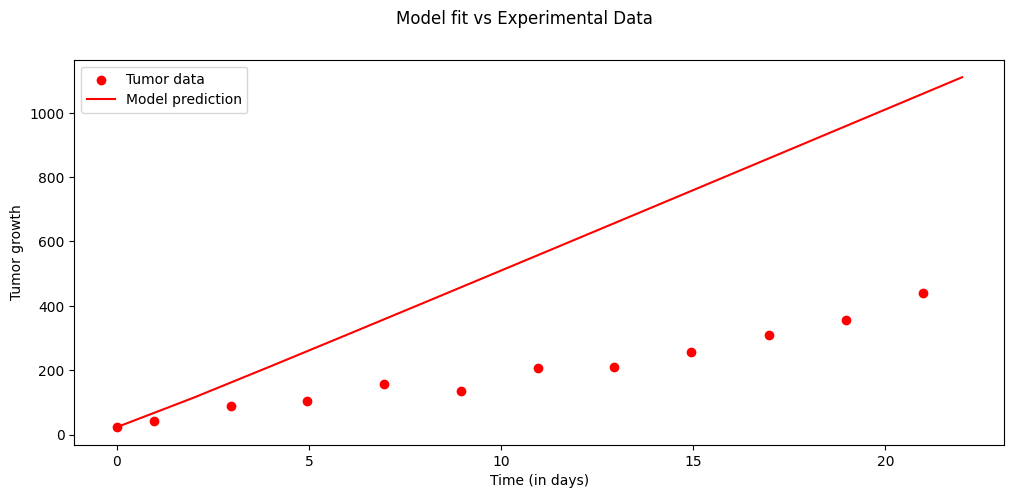

In [94]:
def simulate_model(y0_g, params, t_span, t_eval):
    sol = solve_ivp(full_model_dynamics, t_span, y0_g, t_eval=t_eval, args=tuple(params), method="LSODA", rtol=1e-8, atol=1e-10)
    return sol.t, sol.y.T 

# pick condition (parent virus or virus+IFN)
t_sim = np.linspace(0, max(vsv51_1B[:,0].max(), vsv51_2B[:,0].max()), 100)
t_out, sol = simulate_model(y0_g, f_params_parent, t_span, t_eval)

T_pred = sol[:, 0]  # IFN
E_pred = sol[:, 1]  # virus
I_pred = sol[:, 2]  # IFN
V_pred = sol[:, 3]  # virus
F_pred = sol[:, 4]  # IFN

# Model gives cells
total_cells_pred = T_pred + E_pred + I_pred

# Convert to volume
volume_pred = total_cells_pred 

# plot overlays
fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.scatter(t_tumor_parent, tumor_parent, label="Tumor data", color="red")
ax.plot(t_out, volume_pred, label="Model prediction", color="red")
ax.set_xlabel("Time (in days)")
ax.set_ylabel("Tumor growth")
ax.legend() 


print(tumor_parent, volume_pred, T_pred, E_pred, I_pred)

plt.suptitle("Model fit vs Experimental Data")
plt.show()

[ 24.9915579   27.01178958  35.85030318  56.05261999  64.89113359
  66.91136527 109.84128848 134.58325381 152.51868274 206.80653639
 249.74233237 285.84810089] [  22.71879726  114.40819639  211.80619138  310.53494822  409.86325664
  509.53302729  609.42329911  709.46769373  809.62586572  909.87146907
 1010.18635317 1110.55748287] [  22.71879726  114.40819639  211.80619138  310.53494822  409.86325664
  509.53302729  609.42329911  709.46769373  809.62586572  909.87146907
 1010.18635317 1110.55748287] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


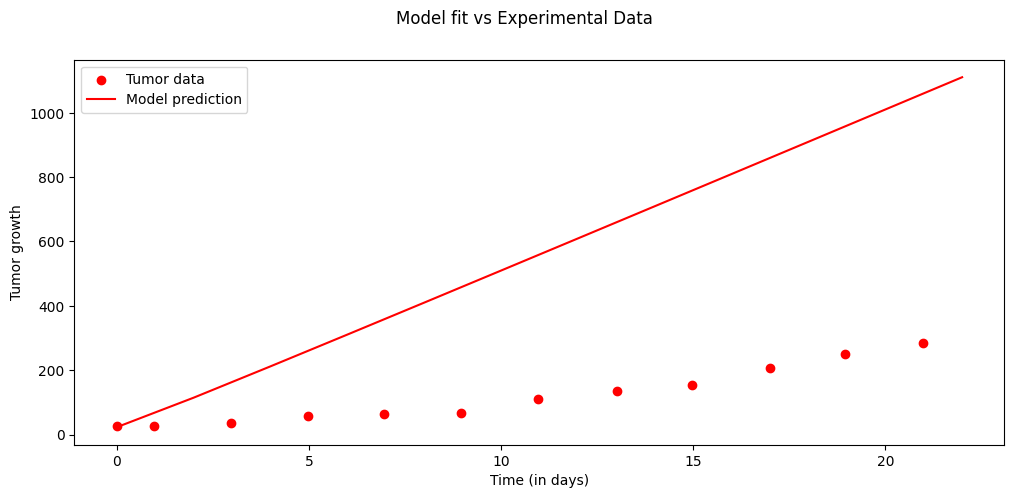

In [41]:
def simulate_model(y0_g, params, t_span, t_eval):
    sol = solve_ivp(full_model_dynamics, t_span, y0_g, t_eval=t_eval, args=tuple(params), method="LSODA", rtol=1e-8, atol=1e-10)
    return sol.t, sol.y.T 

# pick condition (parent virus or virus+IFN)
t_sim = np.linspace(0, max(IFN_1B[:,0].max(), IFN_2B[:,0].max()), 200)
t_out, sol = simulate_model(y0_g, f_params_IFN, t_span, t_eval)

T_pred = sol[:, 0]  # IFN
E_pred = sol[:, 1]  # virus
I_pred = sol[:, 2]  # IFN
V_pred = sol[:, 3]  # virus
F_pred = sol[:, 4]  # IFN

# Model gives cells
total_cells_pred = T_pred + E_pred + I_pred

# Convert to volume
volume_pred = total_cells_pred

# plot overlays
fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.scatter(t_tumor_IFN, tumor_IFN, label="Tumor data", color="red")
ax.plot(t_out, volume_pred, label="Model prediction", color="red")
ax.set_xlabel("Time (in days)")
ax.set_ylabel("Tumor growth")
ax.legend() 


print(tumor_IFN, volume_pred, T_pred, E_pred, I_pred)

plt.suptitle("Model fit vs Experimental Data")
plt.show()